In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tqdm

In [6]:
rng = np.random.default_rng(7)

In [16]:
# model parameters
params = {
    'k_on': 1,
    'k_off': 1,
    'k_tx': 2,
    'k_deg': 1,
}

# simulate sample (beta-poisson)
rho = rng.beta(params['k_on'] / params['k_deg'], params['k_off'] / params['k_deg'], size=1000)
sample = rng.poisson(rho * params['k_tx'] / params['k_deg'], size=1000)

# capture efficiencies
beta = rng.beta(1, 2, size=1000)

# downsample
downsampled = rng.binomial(sample, beta)

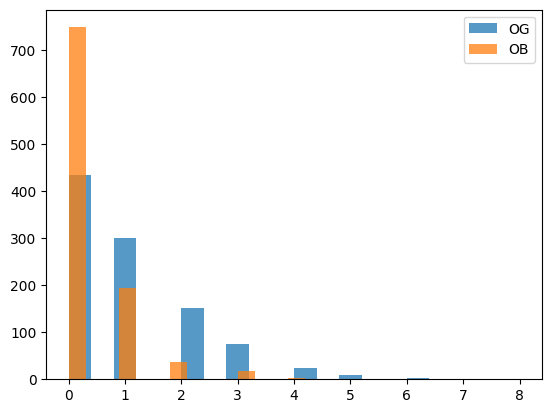

In [17]:
plt.hist(sample, alpha=0.75, label="OG", bins=20);
plt.hist(downsampled, alpha=0.75, label="OB", bins=20);
plt.legend()

In [18]:
def bootstrap_p(downsampled, N=1000, n=1000):
    '''
    N: number of bootstrap samples
    n: size of each bootstrap sample
    '''

    # number of m's observed
    M = int(np.max(downsampled)) + 1

    # setup estimates for p(m) for each m in each resample
    estimates = np.empty((N, M))

    # for each bootstrap sample
    for i in range(N):

        # resample
        boot = rng.choice(downsampled, size=n)

        # compute estimates over resample
        for m in range(M):
            estimates[i, m] = int((boot == m).sum()) / n

    # take quantiles across bootstrap samples
    intervals = np.quantile(estimates, [0.025, 0.975], axis=0)

    return intervals

In [19]:
def bootstrap_conditional(m, beta, downsampled, N=1000, n=1000):
    '''
    N: number of bootstrap samples
    n: size of each bootstrap sample
    '''

    # capture for cells with downsampled count m
    beta_m = beta[downsampled == m]

    # number of unique betas
    M = np.unique(beta).size

    # setup estimates for p(beta|m) for each beta in each resample
    estimates = np.empty((N, M))

    # for each bootstrap sample
    for i in range(N):

        # resample
        boot = rng.choice(beta_m, size=n)

        # compute estimates over resample
        for j in range(M):
            estimates[i, j] = int((boot == beta[j]).sum()) / n

    # take quantiles across bootstrap samples
    intervals = np.quantile(estimates, [0.025, 0.975], axis=0)

    return intervals

## Bootstrapped p(m)

- add beta-poisson truth

In [ ]:
#M = 8
#p = np.zeros(M)
#for b in beta:
#    p += scipy.stats.poisson.pmf([m for m in range(M)], scipy.stats.beta.pdf(b, params['k_on'] / params['k_deg'], params['k_off'] / params['k_deg']) * params['k_tx'] / params['k_deg']) / len(beta)

In [32]:
p_est = bootstrap_p(downsampled)

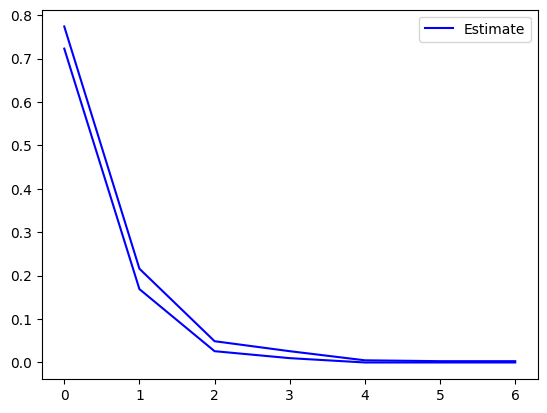

In [33]:
#plt.plot(p, color="red", label="Truth")
plt.plot(p_est[0, :], color="blue", label="Estimate")
plt.plot(p_est[1, :], color="blue")
plt.legend()

## Distribution fit of p(k_c|m) slow 

- tried bootstrapping Beta(a, b) fit a, b parameters, but intervals of a and b wont give intervals on prob values
- need to compute full distribution vaues for all c in bootstrap, then quantile over prob values

BUT pdf values, as continuous distribution...

In [94]:
# count
m = 0

# capture for cells with downsampled count m
beta_m = beta[downsampled == m]

# bootstrap
N = 1000
n = beta_m.size
estimates = np.empty((N, len(beta)))
for i in tqdm.tqdm(range(N)):
    boot = rng.choice(beta_m, n)
    a, b, _, _ = scipy.stats.beta.fit(boot)
    estimates[i, :] = scipy.stats.beta.pdf(beta, a, b)
p_kc_m = np.quantile(estimates, [0.025, 0.975], axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
100%|██████████| 1000/1000 [04:09<00:00,  4.00it/s]


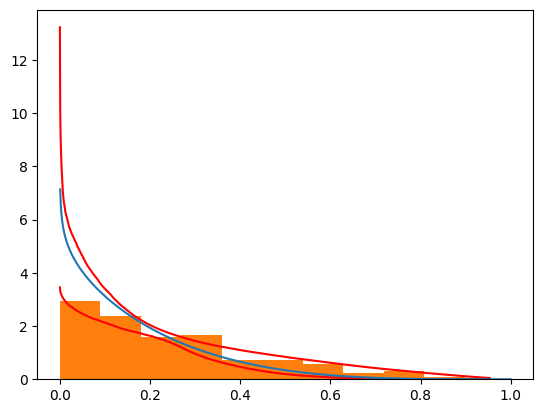

In [130]:
# sort (beta, p(beta|m)) pairs for curve plot
beta_sorted, lb_sorted = zip(*sorted(zip(beta, p_kc_m[0, :])))
beta_sorted, ub_sorted = zip(*sorted(zip(beta, p_kc_m[1, :])))

# plot
plt.plot(beta_sorted, lb_sorted, color="red")
plt.plot(beta_sorted, ub_sorted, color="red")
xs = np.linspace(0, 1, 1000)
plt.plot(xs, scipy.stats.beta.pdf(xs, 0.9, 4.5))
plt.hist(beta_m, density=True);

## Bootstrapped p(k_c|m) very poor

All lower bounds 0 and only few upper bound around 1 / n, because beta values are samples from continuous distribution so unique and bootstrap cannot estimate well

In [31]:
# computing p(k_c|m) = p(b|m)
m = 0
c = 1
b = beta[c]

# compute p(m) exact value
p = 0
for bt in beta:
    p += scipy.stats.poisson.pmf(m, bt*params['k_tx']/params['k_deg']) / len(beta)

# exact value
val = scipy.stats.poisson.pmf(m, b*params['k_tx']/params['k_deg']) * (1 / len(beta)) / p

# bootstrapped value
est = bootstrap_conditional(m, beta, downsampled)[:, c]

# compare
print(val, est)

0.00069693855982417 [0. 0.]


### Illustration of p(k_c|m)

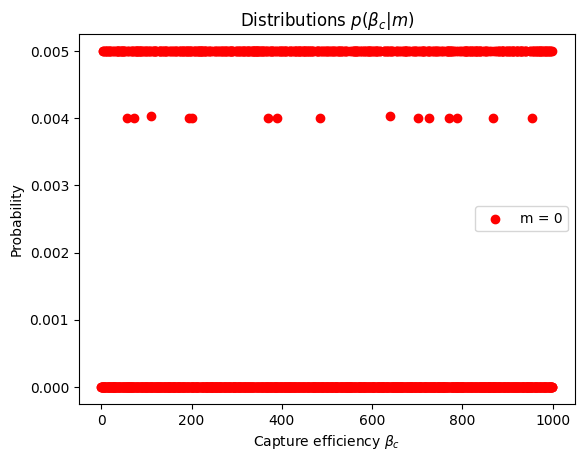

In [30]:
M = 1
colours = ["red", "blue", "green", "orange", "black"]
fig, axs = plt.subplots()
for m in range(M):
    # estimate p(k_c|m)
    p_kc_est = bootstrap_conditional(m, beta, downsampled)
    xs = [i for i, _ in enumerate(beta)]
    plt.scatter(xs, p_kc_est[0, :], c=colours[m % len(colours)], label=f"m = {m}")
    plt.scatter(xs, p_kc_est[1, :], c=colours[m % len(colours)])
#axs.set_xticks(range(len(beta)))
#axs.set_xticklabels(beta_dist)
axs.set_xlabel(r"Capture efficiency $\beta_{c}$")
axs.set_ylabel("Probability")
axs.set_title(r"Distributions $p(\beta_{c} | m)$")
plt.legend()

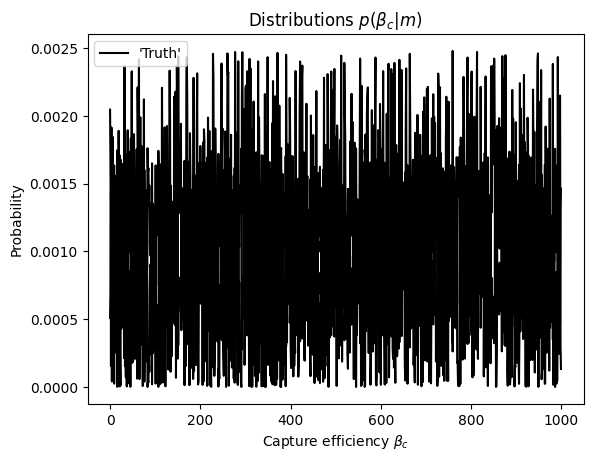

In [34]:
M = 10

# exact p(m)'s
p = np.zeros(M)
for b in beta:
    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta)

# exact p(k_c|m)'s
p_kc = np.zeros((len(beta), M))
for j, b in enumerate(beta):
    for m in range(M):
        p_kc[j, m] = scipy.stats.poisson.pmf(m, b*params['k_tx']/params['k_deg']) * (1 / len(beta)) / p[m]

m_list = [0, 2]
colours = ["red", "blue", "green", "orange", "black"]
fig, axs = plt.subplots()
true_label="'Truth'"
for m in m_list:
    # estimate p(k_c|m)
    #p_kc_est = bootstrap_conditional(m, beta, downsampled)
    plt.plot(p_kc[:, m], "black", label=true_label)
    #plt.plot(p_kc_est[0, :], colours[m % len(colours)], label=f"m = {m}")
    #plt.plot(p_kc_est[1, :], colours[m % len(colours)])
    true_label=None
#axs.set_xticks(range(len(beta_dist)))
#axs.set_xticklabels(beta_dist)
axs.set_xlabel(r"Capture efficiency $\beta_{c}$")
axs.set_ylabel("Probability")
axs.set_title(r"Distributions $p(\beta_{c} | m)$")
plt.legend()

## Direct bootstrap f_m 

In [34]:
def fm_bootstrap(m, beta, downsampled):

    # capture for cells with downsampled count m
    beta_m = beta[downsampled == m]

    # bootstrap E[beta|m]
    N = 1000
    n = beta_m.size
    boot = rng.choice(beta_m, (N, n))
    estimates = boot.mean(axis=1)
    fm = np.quantile(estimates, [0.025, 0.975], axis=0) * params['k_tx']

    return fm

In [37]:
M = 5

# exact p(m) dist
#p = np.zeros(M)
#for b in beta:
#    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta)

# exact f_m's
#fms = np.zeros(M)
#for m in range(M):
#    for b in beta:
#        fms[m] += b * params['k_tx'] * scipy.stats.poisson.pmf(m, b*params['k_tx']/params['k_deg']) * (1 / len(beta)) / p[m]

# estimated f_m's
fms_lb = np.zeros(M)
fms_ub = np.zeros(M)
for m in range(M):
    lb, ub = fm_bootstrap(m, beta, downsampled)
    fms_lb[m] = lb
    fms_ub[m] = ub

Text(0, 0.5, '$f_{m}$')

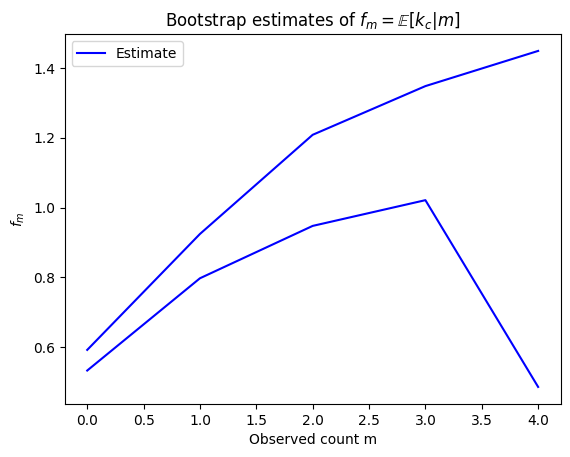

In [38]:
# plt.plot(fms, color="red", label="Truth")
plt.plot(fms_lb, color="blue", label="Estimate")
plt.plot(fms_ub, color="blue")
plt.legend()
plt.title(r"Bootstrap estimates of $f_{m} = \mathbb{E}[k_{c}\vert m]$")
plt.xlabel("Observed count m")
plt.ylabel(r"$f_{m}$")

## Exact values satisfy CME

In [179]:
M = 3
p = np.zeros(M)
for b in beta:
    p += scipy.stats.poisson.pmf([m for m in range(M)], b * params['k_tx'] / params['k_deg']) / len(beta)

f0 = 0
for b in beta:
    f0 += b * params['k_tx'] * scipy.stats.poisson.pmf(0, b*params['k_tx']/params['k_deg']) * (1 / len(beta)) / p[0]

f1 = 0
for b in beta:
    f1 += b * params['k_tx'] * scipy.stats.poisson.pmf(1, b*params['k_tx']/params['k_deg']) * (1 / len(beta)) / p[1]

In [180]:
m = 1
f0*p[m - 1] - f1*p[m] + params['k_deg']*(m + 1)*p[m + 1] - params['k_deg']*m*p[m]

np.float64(4.996003610813204e-16)

In [181]:
# NOTE: fm = (m + 1) p(m + 1) / p(m)
d1 = f1 - (1 + 1) * p[2] / p[1]
d2 = f0 - (0 + 1) * p[1] / p[0]

d1, d2

(np.float64(-3.3306690738754696e-16), np.float64(6.661338147750939e-16))

## Direct bootstrap f_m values satisfy CME (fairly tight bounds)

In [39]:
# estimate p(m)'s
p_est = bootstrap_p(downsampled)

# estimate f_m's
M = 6
fm_est = np.array([fm_bootstrap(m, beta, downsampled) for m in range(M)]).T

In [ ]:
m = 0
g = 0

# lower bound
lb = params['k_on'] * g * p

lb = fm_est[0, m - 1]*p_est[0, m - 1] - fm_est[1, m]*p_est[1, m] + params['k_deg']*(m + 1)*p_est[0, m + 1] - params['k_deg']*m*p_est[1, m]

# upper bound
ub = fm_est[1, m - 1]*p_est[1, m - 1] - fm_est[0, m]*p_est[0, m] + params['k_deg']*(m + 1)*p_est[1, m + 1] - params['k_deg']*m*p_est[0, m]

lb, ub

(np.float64(-0.05217181429552814), np.float64(0.07388457262459078))

## Bootstrapped values satisfy CME (BUT bootstrapped bounds are very wide)

NOTE: need to flip intervals when subtracting (lower bound = negative upper bound)

In [141]:
# estimate p(m)'s
p_est = bootstrap_p(downsampled)

# estimate p(k_c|m)'s
p_kc_0 = bootstrap_conditional(0, beta, downsampled)
p_kc_1 = bootstrap_conditional(1, beta, downsampled)

# estimate fm's
f0_est = np.zeros(2)
f1_est = np.zeros(2)
for j, b in enumerate(beta):
    f0_est += b * params['k_tx'] * p_kc_0[:, j]
    f1_est += b * params['k_tx'] * p_kc_1[:, j]

In [142]:
m = 1

# lower bound
lb = f0_est[0]*p_est[0, m - 1] - f1_est[1]*p_est[1, m] + params['k_deg']*(m + 1)*p_est[0, m + 1] - params['k_deg']*m*p_est[1, m]

# upper bound
ub = f0_est[1]*p_est[1, m - 1] - f1_est[0]*p_est[0, m] + params['k_deg']*(m + 1)*p_est[1, m + 1] - params['k_deg']*m*p_est[0, m]

lb, ub

(np.float64(-0.6566937528579688), np.float64(0.77359482971411))